In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tsfresh

from sklearn import linear_model, model_selection, metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFECV

from scipy.stats import boxcox

%matplotlib inline

In [327]:
# read dataframe from covid_explore.ipynb output
covid = pd.read_csv("./data/covid/covid19_20210104_mod.csv", index_col='date', parse_dates=True)
# select columns of interest and remove all dates up to July 1
covid_mod = covid.loc['2020-07-01':,('days_elapse', 'new_count_update')].copy()
#covid_mod.reset_index(inplace=True, drop=True)
covid_mod.columns = ['days_elapse', 'daily_case']
# add a 3, 5, 7 and 14-day rolling mean
# also add a 14-day rolling std-dev in the event a 14-day standardization is used
covid_mod['daily_case_3mean'] = covid_mod['daily_case'].rolling(window = 3).mean()
covid_mod['daily_case_5mean'] = covid_mod['daily_case'].rolling(window = 5).mean()
covid_mod['daily_case_7mean'] = covid_mod['daily_case'].rolling(window = 7).mean()
covid_mod['daily_case_14mean'] = covid_mod['daily_case'].rolling(window = 14).mean()

In [328]:
covid_mod['daily_case' + "_bc"], lam = boxcox(covid_mod['daily_case'])
shifted = covid_mod - covid_mod.shift(1)

In [330]:
lam

0.11500429578234016

In [331]:
covid_mod

,days_elapse,daily_case,daily_case_3mean,daily_case_5mean,daily_case_7mean,daily_case_14mean,daily_case_bc
date,,,,,,,
2020-07-01,152,12.0,NaN,NaN,NaN,NaN,2.876353
2020-07-02,153,12.0,NaN,NaN,NaN,NaN,2.876353
2020-07-03,154,7.0,10.333333,NaN,NaN,NaN,2.180839
2020-07-04,155,10.0,9.666667,NaN,NaN,NaN,2.636246
2020-07-05,156,10.0,9.000000,10.2,NaN,NaN,2.636246
...,...,...,...,...,...,...,...
2020-12-27,331,424.0,461.000000,496.4,493.428571,557.714286,8.740570
2020-12-28,332,441.0,437.333333,481.2,480.857143,535.000000,8.819576
2020-12-29,333,382.0,415.666667,441.2,472.142857,525.142857,8.532651


In [332]:
shifted + covid_mod.shift(1)

,days_elapse,daily_case,daily_case_3mean,daily_case_5mean,daily_case_7mean,daily_case_14mean,daily_case_bc
date,,,,,,,
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-02,153.0,12.0,NaN,NaN,NaN,NaN,2.876353
2020-07-03,154.0,7.0,NaN,NaN,NaN,NaN,2.180839
2020-07-04,155.0,10.0,9.666667,NaN,NaN,NaN,2.636246
2020-07-05,156.0,10.0,9.000000,NaN,NaN,NaN,2.636246
...,...,...,...,...,...,...,...
2020-12-27,331.0,424.0,461.000000,496.4,493.428571,557.714286,8.740570
2020-12-28,332.0,441.0,437.333333,481.2,480.857143,535.000000,8.819576
2020-12-29,333.0,382.0,415.666667,441.2,472.142857,525.142857,8.532651


In [333]:
def boxcox_inverse(value, lam):
    if (lam * value + 1) <= 0:
        return 0
    if lam == 0:
        return math.exp(value)
    return math.exp(math.log(lam * value + 1) / lam)

In [334]:
covid_7day = pd.Series(shifted['daily_case_bc'], index = shifted.index).dropna()

In [335]:
rolled1 = tsfresh.utilities.dataframe_functions.make_forecasting_frame(covid_7day, kind=1, max_timeshift=14, rolling_direction=1)
rolled2 = tsfresh.utilities.dataframe_functions.make_forecasting_frame(covid_7day, kind=1, max_timeshift=7, rolling_direction=1)

Rolling: 100%|██████████| 27/27 [00:02<00:00, 11.84it/s]


In [336]:
rolled1_mod = rolled1[0].groupby('id').filter(lambda x: len(x) >= 14)
rolled2_mod = rolled2[0].groupby('id').filter(lambda x: len(x) >= 7)

In [337]:
extracted_features1 = tsfresh.extract_features(rolled1_mod, column_id = 'id', column_sort = 'time', column_value = 'value')
extracted_features2 = tsfresh.extract_features(rolled2_mod, column_id = 'id', column_sort = 'time', column_value = 'value')

Feature Extraction: 100%|██████████| 30/30 [00:03<00:00,  7.53it/s]


In [338]:
extracted_features1 = extracted_features1.droplevel(0).add_suffix('_14')
extracted_features2 = extracted_features2.droplevel(0).add_suffix('_7')

In [339]:
extracted_features_combo = pd.concat([extracted_features1, extracted_features2], axis = 1, join='inner')

In [340]:
extracted_features_combo.head()

,value__variance_larger_than_standard_deviation_14,value__has_duplicate_max_14,value__has_duplicate_min_14,value__has_duplicate_14,value__sum_values_14,value__abs_energy_14,value__mean_abs_change_14,value__mean_change_14,value__mean_second_derivative_central_14,value__median_14,...,value__fourier_entropy__bins_2_7,value__fourier_entropy__bins_3_7,value__fourier_entropy__bins_5_7,value__fourier_entropy__bins_10_7,value__fourier_entropy__bins_100_7,value__permutation_entropy__dimension_3__tau_1_7,value__permutation_entropy__dimension_4__tau_1_7,value__permutation_entropy__dimension_5__tau_1_7,value__permutation_entropy__dimension_6__tau_1_7,value__permutation_entropy__dimension_7__tau_1_7
2020-07-16,0.0,0.0,0.0,1.0,0.769220,2.237879,0.522759,0.050939,0.086922,0.120053,...,0.693147,0.693147,1.039721,1.039721,1.386294,1.332179,1.386294,1.098612,0.693147,-0.0
2020-07-17,0.0,0.0,0.0,1.0,0.769220,2.237879,0.520197,0.053501,-0.075547,0.120053,...,0.693147,1.039721,1.039721,1.039721,1.386294,1.609438,1.386294,1.098612,0.693147,-0.0
2020-07-18,0.0,0.0,0.0,1.0,1.879858,1.926468,0.463597,-0.003099,0.036272,0.130071,...,0.562335,1.039721,1.039721,1.386294,1.386294,1.609438,1.386294,1.098612,0.693147,-0.0
2020-07-19,0.0,0.0,0.0,1.0,1.712480,1.802033,0.438342,0.022156,-0.010499,0.130071,...,0.562335,0.562335,1.039721,1.386294,1.386294,1.332179,1.386294,1.098612,0.693147,-0.0
2020-07-20,0.0,0.0,0.0,1.0,1.712480,1.802033,0.450891,-0.009607,-0.011598,0.130071,...,0.562335,0.562335,0.562335,1.039721,1.386294,1.332179,1.386294,1.098612,0.693147,-0.0


In [341]:
from tsfresh.utilities.dataframe_functions import impute

In [342]:
impute(extracted_features_combo)

,value__variance_larger_than_standard_deviation_14,value__has_duplicate_max_14,value__has_duplicate_min_14,value__has_duplicate_14,value__sum_values_14,value__abs_energy_14,value__mean_abs_change_14,value__mean_change_14,value__mean_second_derivative_central_14,value__median_14,...,value__fourier_entropy__bins_2_7,value__fourier_entropy__bins_3_7,value__fourier_entropy__bins_5_7,value__fourier_entropy__bins_10_7,value__fourier_entropy__bins_100_7,value__permutation_entropy__dimension_3__tau_1_7,value__permutation_entropy__dimension_4__tau_1_7,value__permutation_entropy__dimension_5__tau_1_7,value__permutation_entropy__dimension_6__tau_1_7,value__permutation_entropy__dimension_7__tau_1_7
2020-07-16,0.0,0.0,0.0,1.0,0.769220,2.237879,0.522759,0.050939,0.086922,0.120053,...,0.693147,0.693147,1.039721,1.039721,1.386294,1.332179,1.386294,1.098612,0.693147,-0.0
2020-07-17,0.0,0.0,0.0,1.0,0.769220,2.237879,0.520197,0.053501,-0.075547,0.120053,...,0.693147,1.039721,1.039721,1.039721,1.386294,1.609438,1.386294,1.098612,0.693147,-0.0
2020-07-18,0.0,0.0,0.0,1.0,1.879858,1.926468,0.463597,-0.003099,0.036272,0.130071,...,0.562335,1.039721,1.039721,1.386294,1.386294,1.609438,1.386294,1.098612,0.693147,-0.0
2020-07-19,0.0,0.0,0.0,1.0,1.712480,1.802033,0.438342,0.022156,-0.010499,0.130071,...,0.562335,0.562335,1.039721,1.386294,1.386294,1.332179,1.386294,1.098612,0.693147,-0.0
2020-07-20,0.0,0.0,0.0,1.0,1.712480,1.802033,0.450891,-0.009607,-0.011598,0.130071,...,0.562335,0.562335,0.562335,1.039721,1.386294,1.332179,1.386294,1.098612,0.693147,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.0,0.0,0.0,0.0,-0.922524,1.739908,0.506455,-0.019116,-0.010223,0.032355,...,0.693147,0.693147,1.039721,1.039721,1.039721,1.054920,1.386294,1.098612,0.693147,-0.0
2020-12-28,0.0,0.0,0.0,0.0,-1.001234,1.750438,0.501528,-0.024043,0.048732,-0.006999,...,0.693147,0.693147,0.693147,1.386294,1.386294,1.054920,1.386294,1.098612,0.693147,-0.0
2020-12-29,0.0,0.0,0.0,0.0,-1.128540,1.714115,0.438873,0.067112,-0.043316,-0.013621,...,0.693147,0.693147,1.039721,1.039721,1.386294,1.332179,1.386294,1.098612,0.693147,-0.0
2020-12-30,0.0,0.0,0.0,0.0,-0.622012,1.166874,0.372804,-0.055254,-0.001690,-0.013621,...,0.693147,1.039721,1.039721,1.039721,1.039721,1.332179,1.386294,1.098612,0.693147,-0.0


In [343]:
covid_7day_trunc = covid_7day['2020-07-16':]

In [344]:
from tsfresh import select_features
features_filtered = select_features(extracted_features_combo, covid_7day_trunc)

In [345]:
features_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169 entries, 2020-07-16 to 2020-12-31
Freq: D
Data columns (total 28 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   value__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)_14       169 non-null    float64
 1   value__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)_7         169 non-null    float64
 2   value__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"_14   169 non-null    float64
 3   value__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)_7        169 non-null    float64
 4   value__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)_7        169 non-null    float64
 5   value__linear_trend__attr_"slope"_14                                   169 non-null    float64
 6   value__linear_trend__attr_"slope"_7                            

In [346]:
X_train = features_filtered[:116]
y_train = covid_7day_trunc[:116]
X_test = features_filtered[116:]
y_test = covid_7day_trunc[116:]

In [347]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116 entries, 2020-07-16 to 2020-11-08
Freq: D
Data columns (total 28 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   value__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)_14       116 non-null    float64
 1   value__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)_7         116 non-null    float64
 2   value__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"_14   116 non-null    float64
 3   value__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)_7        116 non-null    float64
 4   value__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)_7        116 non-null    float64
 5   value__linear_trend__attr_"slope"_14                                   116 non-null    float64
 6   value__linear_trend__attr_"slope"_7                            

In [348]:
y_train

date
2020-07-16    0.000000
2020-07-17    0.415124
2020-07-18    0.288030
2020-07-19    0.000000
2020-07-20    0.000000
                ...   
2020-11-04    0.220427
2020-11-05    0.470813
2020-11-06    0.666987
2020-11-07   -0.079099
2020-11-08   -0.116199
Name: daily_case_bc, Length: 116, dtype: float64

In [349]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [350]:
train_result = model_rf.predict(X_train)
test_result = model_rf.predict(X_test)

In [351]:
total_result = np.concatenate((train_result, test_result))

In [352]:
result_df = pd.DataFrame(total_result, index = features_filtered.index, columns=['modelled'])

In [353]:
result_df = pd.concat([result_df, covid_7day_trunc], axis=1)

In [354]:
result_df

,modelled,daily_case_bc
2020-07-16,0.005278,0.000000
2020-07-17,0.320088,0.415124
2020-07-18,0.049384,0.288030
2020-07-19,-0.090218,0.000000
2020-07-20,-0.026897,0.000000
...,...,...
2020-12-27,-0.100268,-0.106248
2020-12-28,0.153553,0.079006
2020-12-29,0.045692,-0.286925
2020-12-30,0.632856,0.479543


<AxesSubplot:>

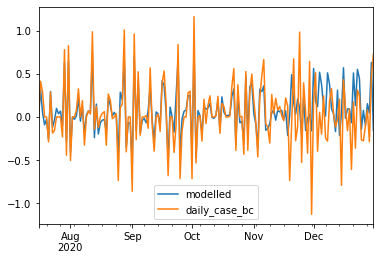

In [355]:
result_df.plot()

In [356]:
result_df_fix = result_df.copy()

In [357]:
result_df_fix['modelled'] = covid_mod.shift(1)['daily_case_bc'] + result_df_fix['modelled']
result_df_fix['daily_case_bc'] = covid_mod.shift(1)['daily_case_bc'] + result_df_fix['daily_case_bc']

In [358]:
result_df_fix2 = result_df_fix.copy()

In [359]:
new_result = result_df_fix2.applymap(lambda x: boxcox_inverse(x, lam))

<AxesSubplot:>

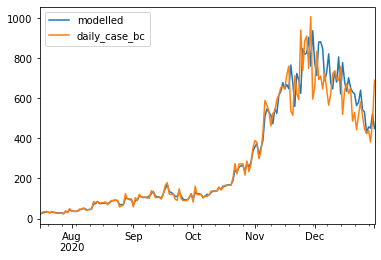

In [360]:
new_result.plot()

In [317]:
def performance(name, observed, modelled):
    output_RMSE = (metrics.mean_squared_error(observed, modelled))**(0.5)
    output_MAE = metrics.mean_absolute_error(observed, modelled)
    output_r2 = metrics.r2_score(observed, modelled)
    
    combine = [output_RMSE, output_MAE, output_r2]
        
    df = pd.DataFrame({name:combine}, index=['RMSE', 'MAE', 'R2'])

    return df

In [318]:
performance('total', new_result['daily_case_bc'], new_result['modelled'])

,total
RMSE,75.487969
MAE,36.984312
R2,0.917349


In [319]:
performance('train', new_result['daily_case_bc'][:116], new_result['modelled'][:116])

,train
RMSE,10.811123
MAE,6.944441
R2,0.990242


In [320]:
performance('test', new_result['daily_case_bc'][116:], new_result['modelled'][116:])

,test
RMSE,133.845669
MAE,102.731952
R2,-0.015865


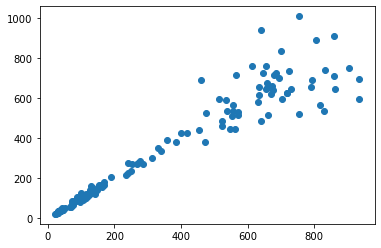

In [321]:
plt.scatter(new_result['modelled'], new_result['daily_case_bc'])

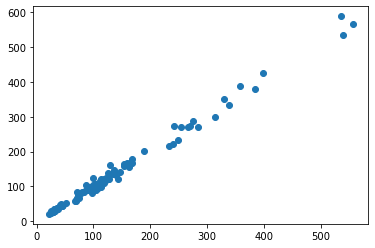

In [322]:
plt.scatter(new_result['modelled'][:116], new_result['daily_case_bc'][:116])

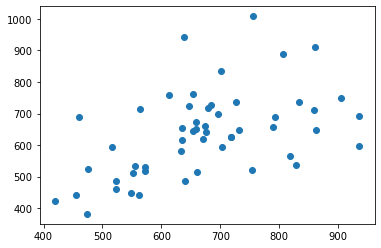

In [323]:
plt.scatter(new_result['modelled'][116:], new_result['daily_case_bc'][116:])

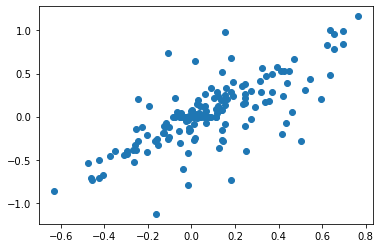

In [324]:
plt.scatter(result_df['modelled'], result_df['daily_case_bc'])

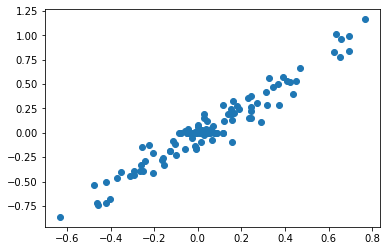

In [325]:
plt.scatter(result_df['modelled'][:116], result_df['daily_case_bc'][:116])

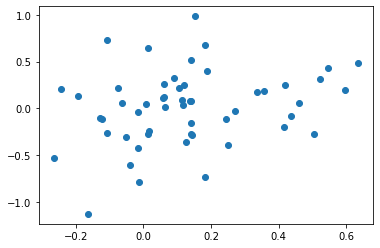

In [326]:
plt.scatter(result_df['modelled'][116:], result_df['daily_case_bc'][116:])